In [1]:
import torch
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
X, y = make_moons(n_samples=50, noise=0.1)
X

array([[ 0.52068266, -0.52465358],
       [ 0.80921632,  0.21055776],
       [-0.01830456, -0.03135836],
       [ 0.06779634,  0.12749541],
       [ 1.44758907, -0.17511068],
       [-0.3970264 ,  0.79485382],
       [-0.88928612,  0.61243914],
       [ 1.89666287,  0.29219755],
       [-0.51926207,  0.79695009],
       [ 0.10922071,  0.85500973],
       [ 0.88330301, -0.36391604],
       [ 1.81401392,  0.36953348],
       [ 0.45706493,  0.83609305],
       [ 0.95514152,  0.43966951],
       [ 0.40878192, -0.42683277],
       [ 2.11109704,  0.08873102],
       [ 0.09297478,  0.51792862],
       [ 1.7328043 , -0.03210962],
       [-1.01936629, -0.03756396],
       [ 0.63398014,  0.80554793],
       [ 1.0427693 , -0.46026475],
       [ 1.5050355 , -0.38521728],
       [ 1.61488693, -0.42561074],
       [-0.05327268,  0.34884182],
       [ 0.07312809,  1.00357776],
       [ 1.69982584, -0.13986013],
       [-0.84624584,  0.61509113],
       [ 0.53688292,  0.55832887],
       [-1.08205455,

In [3]:
# Moons
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y).float()

# pick some points to delete
X_del = []
y_del = []

for i in range(50):
    if y[i] == 1 and X[i, 0] < 0 and X[i, 1] > 0:
        X_del.append([X[i,0],X[i,1]])
        y_del.append(y[i])


y = y.view(-1)
y_del = torch.tensor(y_del).view(-1)
X_del = torch.tensor(X_del)
X_del = X_del.float()
y_del = y_del.float()

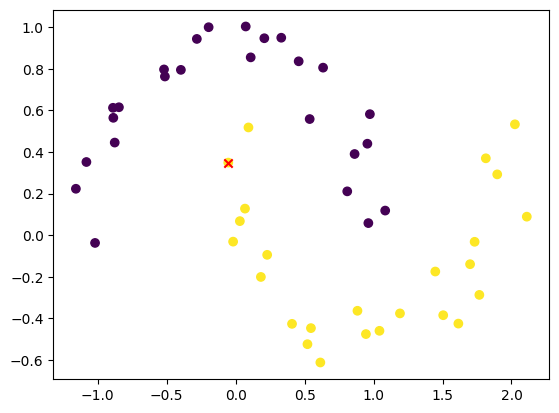

In [4]:
# plot the data points above

plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='r')
plt.show()

In [5]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        prob = torch.sigmoid(logits)

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return prob

In [6]:
X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

In [7]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
# x_train = torch.from_numpy(X).float()
# y_train = torch.from_numpy(y).float()

# Run MCMC
mcmc.run(X, y)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [01:17,  1.29it/s, step size=1.69e-02, acc. prob=0.563]


In [8]:
from pyro.infer import Predictive
import numpy as np

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x1_test = torch.linspace(-1, 2, 1000)
x2_test = torch.linspace(-1, 1.5, 1000)
x_test = np.array(np.meshgrid(x1_test, x2_test)).T.reshape(-1, 2)
x_test = torch.tensor(x_test).float()
preds = predictive(x_test)

In [9]:
preds

{'obs': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]])}

In [10]:
preds["obs"].shape

torch.Size([50, 1000000])

In [11]:
preds_mean = preds["obs"].mean(0)
preds_mean.shape

torch.Size([1000000])

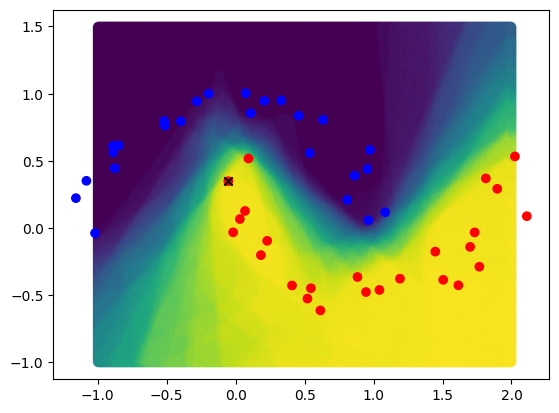

In [12]:
# plot the data points above for each grid point
plt.scatter(x_test[:,0], x_test[:,1], c=preds_mean, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='black')
plt.show()

In [13]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-1, 2]
    ylims = [-1, 1.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    # Plot training data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=75, edgecolor="k", linewidth=1)
    plt.scatter(X_del[:, 0], X_del[:, 1], marker='x', c='r', s=75, linewidth=1)
    plt.contourf(x1_test.reshape(-1, 1), x2_test.reshape(-1, 1), y_pred.reshape(-1, 1), cmap='coolwarm', alpha=0.2)
    plt.colorbar()
    plt.legend(loc=4, fontsize=15, frameon=False)

    plt.show()


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1000000, 1)

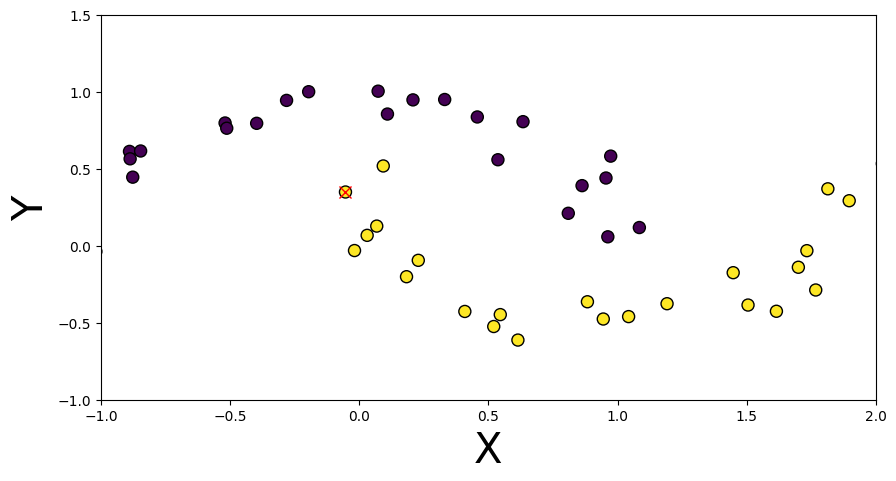

In [14]:
plot_predictions(preds)

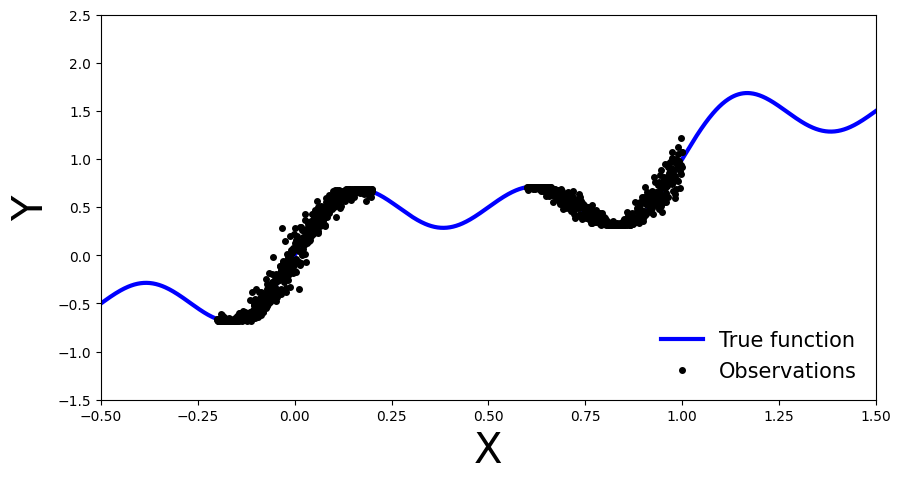

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

In [16]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return obs

In [17]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [04:15,  2.55s/it, step size=3.53e-04, acc. prob=0.968]


In [18]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [19]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

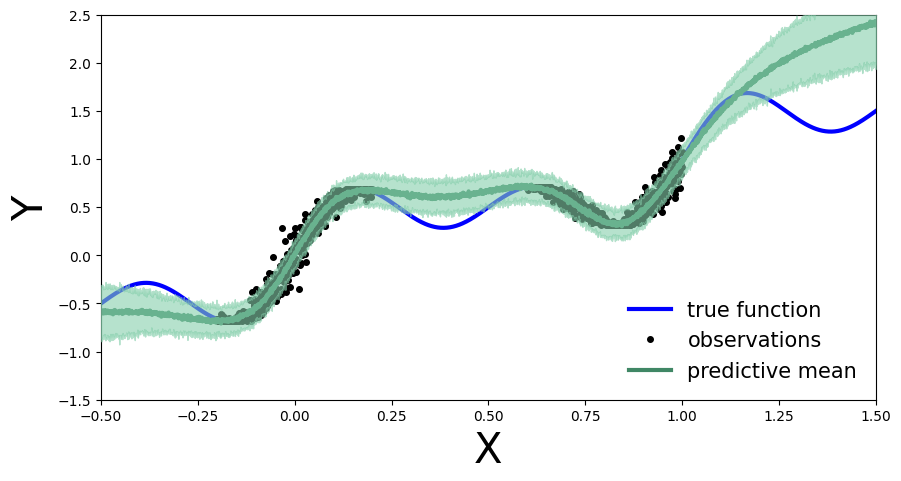

In [20]:
plot_predictions(preds)